<a href="https://colab.research.google.com/github/munich-ml/BER_tail_fit/blob/main/BER_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jitter and BER 
*H. Steffens, April 2021*

This Notebook contains an introduction into Jitter, its correlation to BER (bit error ratio) and how to measure Jitter, particulatly using Xilinx FPGA's with IBERT.

### Jupyter setup
Required Python imports and helper functions


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import special
from scipy.stats import norm

In [2]:
np.random.seed(22)

In [3]:
def get_url(image_name):
    return "https://github.com/munich-ml/BER_tail_fit/blob/main/images/{}.png?raw=true".format(image_name)

# Introduction to Jitter

**Jitter** is the **timing uncertainty** of signal edges at the crossing point with their reference level (0V for differential signaling).

Since **Noise** describes a level uncertainty, **timing noise** or **phase noise** (usually used in frequency domain).

![nice](https://github.com/munich-ml/BER_tail_fit/blob/main/images/RJeye_dscr.png?raw=true)

The **Total Jitter (TJ)** consists of 2 major components:

**Random Jitter (RJ)**
- unbounded --> increases over time
- Gaussian distribution

**Deterministic Jitter (DJ)**
- bounded --> saturates over time 
- can be split into sub-components (e.g. PJ, DCD, ISI)




### Jitter in a transmission system

![Tx+channel+Rx](https://github.com/munich-ml/BER_tail_fit/blob/main/images/tx_channel_rx.png?raw=true)

The Jitter needs to be small enough for the receiver to sample the `rx_data`, while satisfying its setup- and hold-requirements.


# Measure Jitter using a Scope

A scope (realtime oscilloscope) measures jitter directly with the following basic procedure: 
- **wavetrace acquisition** (voltage over time bitstream)
- **edge extraction** (signal crossings with the reference voltage)
- **clock recovery from data** (or usage of a strobe for source syncronous clocking schemas)
- **data eye creastion** (see Tectronix Primer)
- **jitter** (or TIE: time interval error) is now given as edge distribution (e.g. Gaussian shaped)

![eye_creation](https://github.com/munich-ml/BER_tail_fit/blob/main/images/eye_creation.png?raw=true)

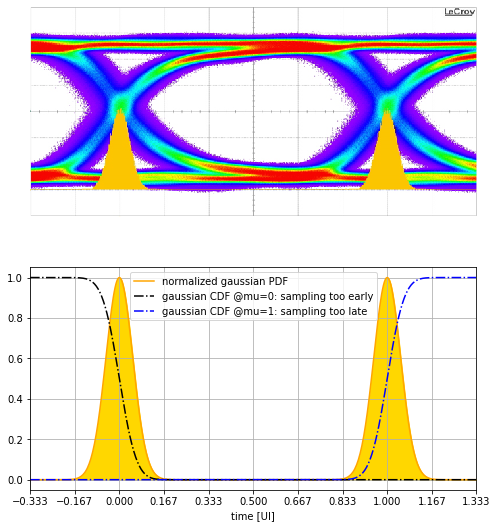

In [32]:
x = np.linspace(-1/3, 4/3, num=500)
scale = 0.05    # sigmal value of the gaussian distribution
norm_pdf = norm.pdf(x, loc=0, scale=scale) + norm.pdf(x, loc=1, scale=scale) 
too_early = 1 - norm.cdf(x, loc=0, scale=scale) 
too_late = norm.cdf(x, loc=1, scale=scale) 

plt.figure(figsize=(8, 9))
plt.subplot(2,1,1)
plt.imshow(plt.imread(get_url("RJeye"))), plt.axis("off")

plt.subplot(2,1,2)
plt.plot(x, norm_pdf / norm_pdf.max(), "orange", label="normalized gaussian PDF")
plt.fill_between(x, norm_pdf / norm_pdf.max(), color="gold")
plt.plot(x, too_early, "k-.", label="gaussian CDF @mu=0: sampling too early")
plt.plot(x, too_late, "b-.", label="gaussian CDF @mu=1: sampling too late")
plt.xlim([min(x), max(x)]), plt.xticks(np.linspace(-1/3, 4/3, num=11))
plt.xlabel("time [UI]"), plt.grid(), plt.legend();

The example above shows a data eye together with the distribution of it's crossings (jitter distribution. PDF).

Integrating the PDF provides the likelyhood of sampling too early or to late (CDF).


### Disadvantages of Jitter measurements using Scopes
Although (realtime-) scopes are are very useful tool when analysing communication systems with respect to Jitter and BER, their usage comes with some disadvantages:
- scopes and probes are expensive
- measurements are only available on individual samples and/or only during test  
- the probes changes the channel, when being applied
- the probes is placed somewhere on the channel, not at the receiver

The **in-system measurement** approach proposed in the next chapter can potentially mitigate or even solve those issues.

# XILINX IBERT

FPGA-maker XILINX offers **Integrated Bit Error Ratio Tester IBERT** for their [7-Series GTP transceivers](https://www.xilinx.com/support/documentation/white_papers/wp428-7Series-Serial-Link-Signal-Analysis.pdf) and [UltraScale/UltraScale+ GTX and GTY transceivers](https://www.xilinx.com/products/intellectual-property/ibert_ultrascale_gth.html#overview).


![WP482](https://github.com/munich-ml/BER_tail_fit/blob/main/images/wp482.png?raw=true)


# Jitter and BER Simulation

## Transmitter

#### Simulation constants

In [7]:
N = int(4e5)      # number of simulated bits
DR = 1e9          # data rate [bits/s]
UI = 1/DR         # unit interval [s]
RJ_SIGMA = 0.025  # simulated random jitter's sigma
PJ_FREQ = 3e5     # frequency of the periodic jitter
PJ_AMPL = 0.1     # periodic jitter amplitude [UI]

### RJ, DJ, TJ simulation

In [8]:
t = np.linspace(start=0, stop=(N-1)*UI, num=N)   # time vector
dj = PJ_AMPL * np.sin(2 * np.pi * PJ_FREQ * t)   # determistic jitter,  consists of PJ, only
rj = RJ_SIGMA * np.random.randn(N)               # random jitter
tj = rj + dj                                     # total jitter

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


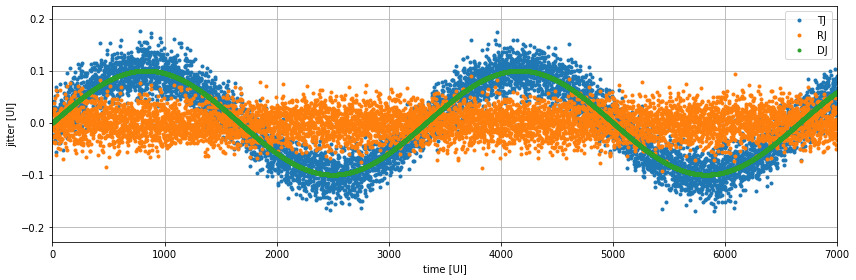

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(tj, ".", label="TJ");
plt.plot(rj, ".", label="RJ");
plt.plot(dj, ".", label="DJ");
plt.xlabel("time [UI]"), plt.ylabel("jitter [UI]")
plt.xlim([0, 7000])
plt.legend(), plt.grid(), plt.tight_layout();

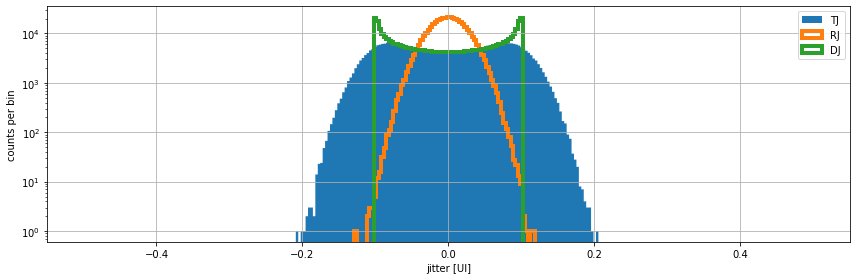

In [10]:
bins = np.linspace(-0.5, 0.5, 300)
plt.figure(figsize=(12, 4))
plt.hist(tj, bins=bins, histtype="stepfilled", label="TJ")
plt.hist(rj, bins=bins, histtype="step", linewidth=4, label="RJ")
plt.hist(dj, bins=bins, histtype="step", linewidth=4, label="DJ")
plt.yscale("log")
plt.ylabel("counts per bin"), plt.xlabel("jitter [UI]")
plt.legend(), plt.grid(), plt.tight_layout();

### Random bit sequence as data

In [11]:
data = np.random.randint(0, 2, N)

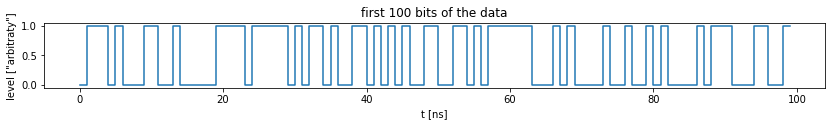

In [12]:
plt.figure(figsize=(14, 1.2))
n = 100    # number of bits shown
sns.lineplot(x=t[:n]*1e9, y=data[:n], drawstyle='steps-post')
plt.title(f"first {n} bits of the data")
plt.xlabel("t [ns]"), plt.ylabel('level ["arbitraty"]');

## Receiver

### Data sampling and error checking
Create a receiver sampler with `65` steps within the unit interval

In [13]:
RX_PI_STEPS = 65          # step count of the receiver phase interpolator
rx_pi = np.linspace(0, 1, num=RX_PI_STEPS)

Cheching for errors

In [14]:
errors = []
for rx_pi_step in rx_pi:
    errors.append(0)      # start with 0 errors at each new RX PI step
    for i, tj_sample in enumerate(tj):
        if 0 < i < N-1:                      # allows sampling data[i-1], data[i+1] 
            if tj_sample > rx_pi_step:         # checking left side eye
                errors[-1] += int(np.logical_xor(data[i-1], data[i]))
            if 1 + tj_sample < rx_pi_step:         # checking left side eye
                errors[-1] += int(np.logical_xor(data[i+1], data[i]))

### Compute and plot BER

In [15]:
ber = np.array(errors) / N

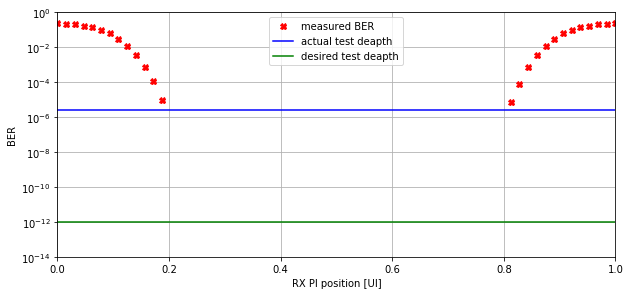

In [16]:
plt.figure(figsize=(10, 4.5))
plt.semilogy(rx_pi, ber, "rX", label="measured BER")
plt.semilogy([0, 1], [1/N, 1/N], "-b", label="actual test deapth")
plt.semilogy([0, 1], [1e-12, 1e-12], "-g", label="desired test deapth")
plt.xlabel("RX PI position [UI]"), plt.ylabel("BER")
plt.xlim([0, 1]), plt.ylim([1e-14, 1])
plt.legend(), plt.grid();

# Gaussian tail fit

# Conclusion